
# <center>**Classification - Message spam or no spam**</center>

## **Table of Contents**

**1. [Problem Statement](#section1)<br>**
**2. [Importing Packages](#section2)<br>**
**3. [Loading Data](#section3)<br>**
 - **3.1 [Description of the Dataset](#section301)<br>**
 
**4. [Data Preprocessing](#section4)<br>**
**5. [Model Building](#section5)<br>**
**6. [Prediction on test set](#section6)<br>**
**7. [Deployment](#section7)**
**8. [Conclusion](#section7)**

---
<a id=section1></a>
# **1. Problem Statement**
---

- **Filer Power** is one of the top-tier **cyber security companies** in the country.

- They offer **impressive solutions** in terms of **security** and **surveillance** and are known nationwide for their service.

- The company has recently noticed that **the number of spam messages in WhatsApp is increasing day by day.**

- Hence, they want to make a product that can **classify if a message is a fraud or not.**

- In order to execute this task, the company is planning to **introduce a new AI-powered system.**

- This system should easily monitor and determine **if a message is a fraud or not.**




<br> 
<center><img src="https://scholarlyoa.com/wp-content/uploads/2020/01/spam-email-640x565.png" width="700px" height="450px"/></center>
<br> 

### **Scenario:**

- You are given a historical dataset that contains the information of some of the beneficiaries and many factors that determine **if a massage is spam or not.**

- Your task is to build **a binary-class classification model** using this dataset.

- Because there was no machine learning model for this problem in the company, you don’t have a quantifiable win condition. **You need to build the best possible model.**



---
<a id=section2></a>
## **2. Importing Packages**
---
- In this section we will be importing the necessary packages.

In [ ]:
import numpy as np    
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')     # To suppress all the warnings in the notebook.

import os
import zipfile

In [ ]:
import string
from string import punctuation

import re

import nltk
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

In [ ]:
# Import tensorflow 2.x
# This code block will only work in Google Colab.
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

In [ ]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing import text, sequence

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import accuracy_score

2.7.0


### **Download pre-trained embedding**

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
# !apt install unzip
# !unzip "glove.twitter.27B.zip"

---
<a id=section3></a>
# **3. Loading Data**
---

- In this section we will be **loading the datasets** for **train and test data**.

In [ ]:
train=pd.read_csv("/content/WhatsApp_train.csv")
print('Shape of data is ', train.shape)
train.head()

Shape of data is  (1252, 3)


Id                                               Text  Label
0   598  [16:55, 9/28/2020] Kahuthu: Nashindanga kumuit...    0.0
1   914       [09:28, 9/10/2020] +254 718 455166: ????????    0.0
2   819                   Code unaattach yote kwa appendix    0.0
3  1307       [12:38, 9/11/2020] +254 796 166550: Nini iyo    0.0
4   809                   Plus io ya compiler construction    0.0

In [ ]:
test=pd.read_csv("/content/WhatsApp_test.csv")
print('Shape of test data is ', test.shape)
test.head()

Shape of test data is  (314, 2)


Id                                               Text
0   553  [21:19, 9/26/2020] +254 712 306985: ????saa hi...
1   284  [11:59, 9/18/2020] Dan Charles: Hii sem hakuna...
2  1605  [14:46, 9/4/2020] Kasarani: Atatoa list kwa we...
3  1267  [12:13, 9/11/2020] +254 796 166550: Enda any w...
4    60  [16:55, 9/16/2020] +254 719 542420: Shule zina...

<a id=section301></a>
### **3.1 Data Description**

- There are **2 classes**, representating **positive** or **negetive** reviews in the dataset.

- The dataset contains the following columns:
 
 
 | Column Name        | Description                                               |
| -------------      |:-------------                                            :| 
Id | Unique Identifier
Text | Text of the corpus
Label | **`1: If found Spam`** and **`0: If found not spam`**

---
<a id=section4></a>
## **4. Data Preprocessing**
---

- In this section we will preprocess the data.

- We will be removing the unnecessary **Stopwords**

- Then, we will be removing **unwanted html tags**.

- Then we will be removing the **unwanted URLs**

In [ ]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Removing the Html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
#Removing the square brackets and urls
def remove_between_square_brackets(text):
    text = re.sub('\[[^]]*\]', '', text)
    return re.sub(r'http\S+', '', text)

In [ ]:
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

In [ ]:
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [ ]:
#Apply function on review column for training data
train['Text']=train['Text'].apply(denoise_text)

### **Splitting data**

In [ ]:
X_train  = train['Text']
y_train = train['Label']

In [ ]:
# Selecting the maximum features as 10000 and maxlen = 300
max_features = 2294
maxlen = 100

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

### **Loading the Embedded file.**

- We are using `glove.twitter.27B.100d` embedding.

In [ ]:
EMBEDDING_FILE = '/content/glove.twitter.27B.100d.txt'

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

In [ ]:
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
model = Sequential([
  Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False),
  layers.LSTM(units=128, recurrent_dropout = 0.25),
  layers.Dense(2, activation='softmax')
])

### **Inspecting the Model**

- In this section we will be checking the **summary** of the model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          229400    
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 346,906
Trainable params: 117,506
Non-trainable params: 229,400
_________________________________________________________________


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### **Train the Model**

- Training the model for **10 epochs**, with **batch_size** of **128** and **embed_size** of **100**.

- Recording the training and validation accuracy in the `history` object.

In [ ]:
batch_size = 128
epochs = 10
embed_size = 100

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

history = model.fit(X_train,
                    y_train,
                    batch_size = batch_size ,
                    validation_split=0.2 ,
                    epochs = epochs ,
                    callbacks = [learning_rate_reduction])

Epoch 1/10
8/8 [==============================] - 8s 485ms/step - loss: 0.2654 - accuracy: 0.9321 - val_loss: 0.1174 - val_accuracy: 0.9761 - lr: 0.0100
Epoch 2/10
8/8 [==============================] - 3s 430ms/step - loss: 0.1530 - accuracy: 0.9510 - val_loss: 0.0992 - val_accuracy: 0.9761 - lr: 0.0100
Epoch 3/10
8/8 [==============================] - 3s 429ms/step - loss: 0.1166 - accuracy: 0.9580 - val_loss: 0.0842 - val_accuracy: 0.9801 - lr: 0.0100
Epoch 4/10
8/8 [==============================] - 3s 425ms/step - loss: 0.0879 - accuracy: 0.9710 - val_loss: 0.0844 - val_accuracy: 0.9801 - lr: 0.0100
Epoch 5/10
8/8 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9780
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
8/8 [==============================] - 3s 433ms/step - loss: 0.0545 - accuracy: 0.9780 - val_loss: 0.0964 - val_accuracy: 0.9721 - lr: 0.0100
Epoch 6/10
8/8 [==============================] - 3s 425ms/step - loss: 0.0

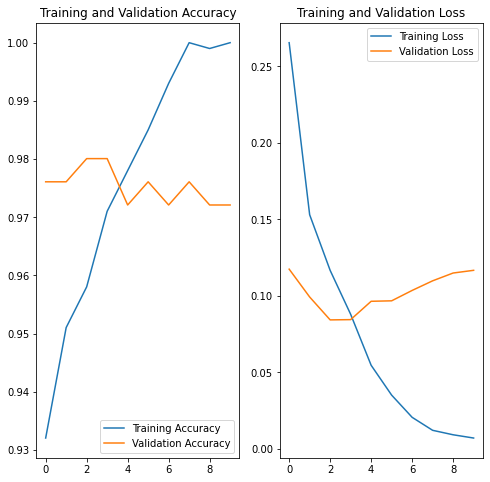

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

- We can see that thought there is slight difference in the **accuracy** the **validation loss** increases after **8th epoch**.

- Hence, the model is **overfitting**.


### **Improving Model**

- Adding a Bidirectional LSTM with **recurrent_droupout** and **droupout** and a dense layer.
   - Bidirectional LSTMs train two instead of one LSTMs on the input sequence.

In [ ]:
model2 = Sequential([Embedding(max_features,
                               output_dim=embed_size,
                               weights=[embedding_matrix],
                               input_length=maxlen,
                               trainable=False),
                     layers.Bidirectional(LSTM(units=128,
                                               recurrent_dropout = 0.25)),
                     layers.Dense(units=32,
                                  activation='relu'),
                     layers.Dense(units=2,
                                  activation='sigmoid')
                     ])

In [ ]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          229400    
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 32)                8224      
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 472,186
Trainable params: 242,786
Non-trainable params: 229,400
_________________________________________________________________


In [ ]:
model2.compile(optimizer=keras.optimizers.Adam(lr = 0.01),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
batch_size = 128
epochs = 10
embed_size = 100

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

history = model2.fit(X_train, y_train,
                     batch_size = batch_size , 
                     validation_split=0.2,
                     epochs = epochs ,
                     callbacks = [learning_rate_reduction])

Epoch 1/10
8/8 [==============================] - 14s 1s/step - loss: 0.2885 - accuracy: 0.9481 - val_loss: 0.1198 - val_accuracy: 0.9761 - lr: 0.0100
Epoch 2/10
8/8 [==============================] - 7s 841ms/step - loss: 0.1992 - accuracy: 0.9481 - val_loss: 0.1286 - val_accuracy: 0.9761 - lr: 0.0100
Epoch 3/10
8/8 [==============================] - 6s 809ms/step - loss: 0.1545 - accuracy: 0.9491 - val_loss: 0.1004 - val_accuracy: 0.9801 - lr: 0.0100
Epoch 4/10
8/8 [==============================] - 7s 821ms/step - loss: 0.1147 - accuracy: 0.9570 - val_loss: 0.1107 - val_accuracy: 0.9681 - lr: 0.0100
Epoch 5/10
8/8 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9690
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
8/8 [==============================] - 7s 827ms/step - loss: 0.0734 - accuracy: 0.9690 - val_loss: 0.0980 - val_accuracy: 0.9761 - lr: 0.0100
Epoch 6/10
8/8 [==============================] - 7s 827ms/step - loss: 0.061

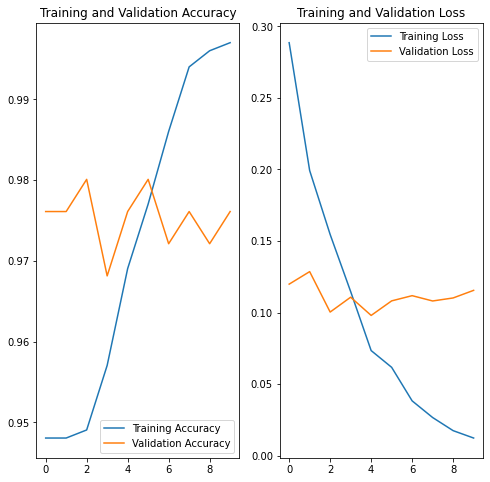

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

- We can see that, this model **performs better** than the previous model.

- Because of this we will use this model to **predict the unseen data**.

---
<a id=section6></a>
#**6. Prediction on test set**
---
- In this section we will be **making predictions on the test set.**

In [ ]:
test['Text']=test['Text'].apply(denoise_text)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(test['Text'])
test_seq = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
# Making predictions on unseen data
predict_y=model.predict(test_seq) 
classes_x=np.argmax(predict_y,axis=1)

In [ ]:
# Loading the actual class labels
y_df = pd.read_csv('/content/WhatsApp_y_test.csv', names=['Id', 'Label'])
y_df.head()

Id  Label
0   553    0.0
1   284    0.0
2  1605    0.0
3  1267    0.0
4    60    0.0

In [ ]:
print('Accuracy score for test data is:', accuracy_score(y_df['Label'],classes_x))

Accuracy score for test data is: 0.9554140127388535


----
<a id=section1></a>
# **7. Model Deployment using GCP App Engine**
---

- Some **cool features** of App Engine

  -  **Scale downs to zero when no traffic/requests** (Cost saving).
  
  - Focus on **writing the code**, rest everything is taken care
  
  - Application **version deployment**, you can **rollback** to the previous version **within seconds**
  
  - **Traffic Splitting**: Split your traffic between two **different versions**. This helps to do **A/B testing** and incremental **feature rollout**.

- **Let get start with deployment:**


<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/ee/mg18.gif" width="500"height = "250"/></center>

<br>  

#### **Create project in Google Cloud Platform**

- In order to **deploy** any application firstly we need to create a **project** in **GCP Console**. 

- Create a new project in **GCP Dashboard**. Provide it a **unique name** and also **notedown** project id for **future references**. 

<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/ee/mg11.png" width="800"height = "430"/></center>

<br>  
<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/ee/mg12.png" width="800"height = "430"/></center>

<br>  

- Creating new project will lead you to the dashboard of that **particular** **project**.

<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/ee/mg13.png" width="800"height = "410"/></center>

<br>  


#### **Create an APP in App Engine**

- Navigate to the **App Engine** to create **an app** in App Engine.

- Select the **location** for your app. In our case we'll use **south-asia-1**(Mumbai) as **our location**. 

<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/ee/mg14.png" width="800"height = "430"/></center>

<br>  
<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/ee/mg15.png" width="800"height = "400"/></center>

<br> 

- After creating project **Activate Cloud Shell**.

- Use the **cloud shell icon** from right side.

<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/sp6.png" width="500"height = "250"/></center>

<br> 



<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/sp8.png" width="800"height = "450"/></center>

<br> 


<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/ee/mg1.png" width="460"height = "250"/></center>

<br>  

- After **activating cloud** shell Clone **Git Repository** of created file. 

      git clone https://gitlab.com/SqweeksOp/spam-classifier.git

- **Navigate to your app directory:**

  - Set the **new working directory** using the following command.

        cd spam-classifier

- Deploy the app **using the following command**. 

      gcloud app deploy app.yaml --project crafty-almanac-268606

<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/sp5.png" width="950"height = "500"/></center>

<br>




- **After the deployment is successful we can visit our deployed app using the link provided.** 

- **Making Prediction on our deployed Model:**

- **Example: 1**

<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/sp1.png" width="800"height = "450"/></center>

<br>  
<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/sp2.png" width="800"height = "450"/></center>

<br>  

- **Example 2:**

<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/sp3.png" width="800"height = "450"/></center>

<br>  
<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/sp4.png" width="800"height = "450"/></center>

<br>  

- **Our Model is deployed to google App Engine:**

<br>  
<center><img src = "https://raw.githubusercontent.com/insaid2018/DeepLearning/master/e2e/ee/mg19.gif" width="600"height = "300"/></center>

----
<a id=section1></a>
# **8. Conclusion**
---

- The process of **AI deployment** is also a **complex** task and requires a **high degree** of planning to be effective.

- According to a survey **60% of models** never make it out into **production**. One of the key hurdles is the **difficulty** of transforming something that works in a **laboratory environment** into a **reliable public** service.

- The **effectiveness** of the model itself is also a **key challenge**. Ensuring results are **accurate** with **no bias** can be difficult. 

- After AI deployment, the model should be **continuously** tested and monitored to **drive improvements** and continuous **optimisation**.
